In [1]:
import torch
import torch.nn as nn

import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import librosa
import librosa.display

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import ArcticDataset, TIMITDataset
from tqdm.notebook import tqdm

import torchvision
import torchvision.transforms as img_transforms

print(torch.__version__)
print(torchaudio.__version__)

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


1.7.1+cu110
0.7.2


/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Utils function for audio representation

In [3]:
def play_audio(data: np.ndarray, rate: int) -> None:
    display(Audio(data, rate=rate))


def plot_waveform(data: np.ndarray, rate: int) -> None:
    plt.figure(figsize=(14, 5))
    plt.plot(data / 2 ** 15)
    plt.show()


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(f'Spectrogram (dB) of {title}')
    axs.set_ylabel('freq bin')

    spec = spec.numpy()
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show()


def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Filter bank')
    axs.imshow(fbank, aspect='auto')
    axs.set_ylabel('frequency bin')
    axs.set_xlabel('mel bin')
    plt.show(block=False)

# Transforms

In [4]:
n_fft = 512
win_length = None
hop_length = 256
n_mels = 128
sample_rate = 16000

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=2.0,
    n_mels=n_mels,
)

transform = nn.Sequential(
    T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=2.0,
        n_mels=n_mels,
    ),
    img_transforms.Resize((128, 128))
)

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


# Dataset

In [5]:
vowel_labels = ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
                'IX', 'AXR', 'AH-H']
consonant_labels = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q',
                    'JH', 'CH', 'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX']
phone_labels = vowel_labels + consonant_labels

In [6]:
timit_dataset_train = TIMITDataset(usage='train', padding=0, percentage=0.8,
                                   root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                   phone_codes=phone_labels)

timit_dataset_test = TIMITDataset(usage='test', padding=0, percentage=0.8,
                                  root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                  phone_codes=phone_labels)

print(f'Length of the train dataset: {len(timit_dataset_train)}')
print(f'Length of the test dataset: {len(timit_dataset_test)}')

Length of the train dataset: 94242
Length of the test dataset: 33814


/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


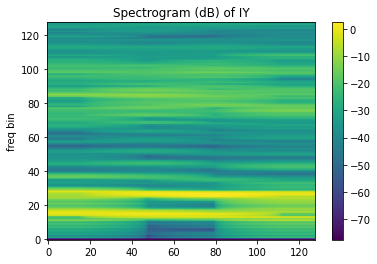

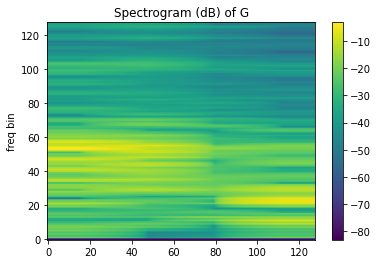

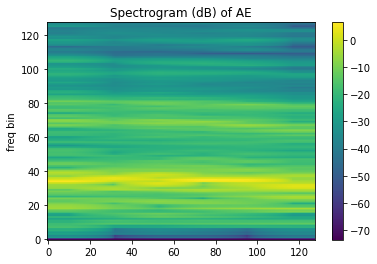

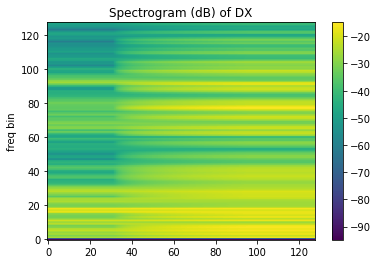

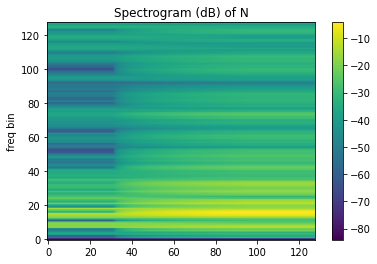

In [7]:
for i in [1, 11, 51, 101, 1001]:
    waveform = timit_dataset_train[i].data
    transformed = transform(waveform)
    plot_spectrogram(transformed[0], title=timit_dataset_train[i].label)

In [8]:
labels = sorted(list(set(datapoint.label for datapoint in timit_dataset_train)))

In [9]:
NUM_OF_CLASSES = len(labels)
NUM_OF_CLASSES

43

In [10]:
def label_to_index(phone):
    return torch.tensor(labels.index(phone))


def index_to_label(index):
    return labels[index]


def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


# Create dataloaders

In [11]:
batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:

    num_workers = 0
    pin_memory = False


def get_loaders(train_set, test_set):
    return torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
), torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Train and test

In [12]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)

        target = target.to(device)

        data = transform(data)
        output = model(data)

        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(pbar_update)

        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        losses.append(loss.item())

In [13]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def test(model, epoch, loader):
    model.eval()
    correct = 0
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    return (correct / len(loader.dataset)) * 100.0

# speechVGG

In [14]:
from models.vgg16 import VGG16, VGG16_E, VGG16_A, VGG16_C

model = VGG16(num_classes=NUM_OF_CLASSES, in_channels=1, architecture=VGG16_C)
model.to(device)
x = torch.randn(1, 1, 128, 128).to(device)
print(model(x).shape)

optimizer = optim.Adam(model.parameters(), lr= 5 * (10 ** -5), weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

print(model)

torch.Size([1, 43])
VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, k

In [15]:
log_interval = 1000
n_epoch = 10

train_loader, test_loader = get_loaders(timit_dataset_train, timit_dataset_test)

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        print(f'Epoch #{epoch}:')
        train(model, epoch, log_interval)
        print(f'On train: {test(model, epoch, train_loader):.0f}%')
        print(f'On test: {test(model, epoch, test_loader):.0f}%')
        scheduler.step()

plt.plot(losses)
plt.title("training loss")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1:
Train Epoch: 1 [0/94242 (0%)]	Loss: 3.715247
Train Epoch: 1 [16000/94242 (17%)]	Loss: 1.803259
Train Epoch: 1 [32000/94242 (34%)]	Loss: 1.382568
Train Epoch: 1 [48000/94242 (51%)]	Loss: 2.243248
Train Epoch: 1 [64000/94242 (68%)]	Loss: 0.923228
Train Epoch: 1 [80000/94242 (85%)]	Loss: 0.668848
On train: 8%
On test: 8%
Epoch #2:
Train Epoch: 2 [0/94242 (0%)]	Loss: 0.816441
Train Epoch: 2 [16000/94242 (17%)]	Loss: 1.863425
Train Epoch: 2 [32000/94242 (34%)]	Loss: 1.257191
Train Epoch: 2 [48000/94242 (51%)]	Loss: 0.955325
Train Epoch: 2 [64000/94242 (68%)]	Loss: 0.800213
Train Epoch: 2 [80000/94242 (85%)]	Loss: 1.180293
On train: 12%
On test: 12%
Epoch #3:
Train Epoch: 3 [0/94242 (0%)]	Loss: 1.451698
Train Epoch: 3 [16000/94242 (17%)]	Loss: 0.681572
Train Epoch: 3 [32000/94242 (34%)]	Loss: 0.848109
Train Epoch: 3 [48000/94242 (51%)]	Loss: 0.849558
Train Epoch: 3 [64000/94242 (68%)]	Loss: 1.082540
Train Epoch: 3 [80000/94242 (85%)]	Loss: 0.922847
On train: 17%
On test: 17%
Epoch 

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), './phoneme_classifier_vgg16_c_1.pth')

# ResNet

In [ ]:
from models.resnet import resnet_50

model = resnet_50(num_classes=NUM_OF_CLASSES)
model.to(device)

x = torch.randn(1, 1, 128, 128).to(device)
print(model(x).shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print(model)